In [2]:
#pandas - they standard data manipulation package
import pandas as pd
#numpy - scientific computation - matrix operations, etc.
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
import copy

### In this project, we will only use features in 'application_train' to create new features and do analysis

#### Read data
Y is the target variable, X includes all features except ID

In [3]:
import os
os.chdir('E:/Files/Toronto Courses/Machine learning/Data/')
train = pd.read_csv('E:/Files/Toronto Courses/Machine learning/Data/application_train.csv',index_col = 0)
Y = train['TARGET']
X = train.drop('TARGET',axis=1)

#### Some functions
BinTree is used to bin feature according to Gini index by DecisionTreeClassifier, to be exact, we bin each feature at the point where the Gini index decrease the most.

WOEIV is used to compute the Weight of Evidence of each bin, and the information value of each feature, usually, higher information value means it has more information about target variable.

In [28]:
#%%
##kde plot
def mmf_kde_plot (X,Y, var_name):
    plt.figure(figsize = (6, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(X[var_name].loc[Y==0], label = 'TARGET == 0')
    sns.kdeplot(X[var_name].loc[Y==1], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend()

## use Decision Tree to bin variable
import sklearn.tree as skt
def BinTree(x,y, groups = None, depth = None, min_impurity_decrease = 0, x_test = None):
    xx = copy.deepcopy(x)
    xx[np.isinf(xx)] = np.nan
    na_pos = pd.isna(xx)
    if na_pos.sum()>0:
        nonna = xx[~na_pos]
        xx[na_pos] = np.nan ## to distinguish other categories
    else:
        nonna = xx
    tree = skt.DecisionTreeClassifier(max_depth = depth,max_features =None,class_weight='balanced',min_impurity_decrease = min_impurity_decrease,max_leaf_nodes=groups)
    tree.fit(nonna.values.reshape(-1,1),y[~na_pos])
    xx[~na_pos] = tree.apply(nonna.values.reshape(-1,1))
    if x_test == None:
        return xx
    else:
        xxx = copy.deepcopy(x_test)
        xxx[~pd.isna(xxx)] = tree.apply(xxx[~pd.isna(xxx)].values.reshape(-1,1))
        return xxx
## for each category in x, compute its WOE and IV
def WOEIV(x,y):
    cate = pd.unique(x)
    total0 = (y==0).sum(); total1 = len(y) - total0
    WOE = []; sub0 = []; sub1 = [];
    for i,category in enumerate(cate):
        if type(category) != np.str:
            if pd.isna(category):
                sub0.append((y[pd.isna(x)]==0).sum()); sub1.append((y[pd.isna(x)]==1).sum())
            else:
                sub0.append((y[x==category]==0).sum()); sub1.append((y[x==category]==1).sum())
        else:
            sub0.append((y[x==category]==0).sum()); sub1.append((y[x==category]==1).sum())
        
        if sub0[i]==0:
            WOE.append(np.log(sub1[i] / total1))
        elif sub1[i]==0:
            WOE.append(-np.log(sub0[i] / total0))
        else:
            WOE.append(np.log(sub0[i] / total0) - np.log(sub1[i] / total1))
    
    WOE = np.array(WOE) ;sub0 = np.array(sub0); sub1 = np.array(sub1)
    return [WOE,(sub0/total0 - sub1/total1) * WOE,np.sum((sub0/total0 - sub1/total1) * WOE)]

#### Transform all features into WOE
Below, we use BinTree to bin all continuous features, then we replace each category in each feature with its WoE, at the same, we compute the Information value of each feature. Note that, there may be part of data leakage as we need to use target variable to compute WoE and IV, but this is acceptable because it only leaks the information of train dataset. There is no data leakage if we apply the model to test data. In addition, through binning the feature, we are able to capture the nonlinear relation and it's easy for business to understand when building scorecard.

We use 0.02 as threshold to delete features which almost has no information about the target, so we finally get 56 useful features which will be used to build model.

In [7]:
#%% transform feature into WOE
X_copy = copy.deepcopy(X)
#test_copy = copy.deepcopy(test)
'''
for name in X_copy.columns:
    print('---',name,'---')
    print(X_copy[name].dtype)
'''
## compute IV for all variables
iv = []
for i,name in enumerate(X_copy.columns):
    x = X_copy[name]
    if x.dtype == np.float64  and len(pd.unique(x)) > 8: ##check it's continuous or categorical feature, bin continuous feature
        x = BinTree(x,Y,min_impurity_decrease = 0.0001,groups = 8, depth = 5)
    woe = WOEIV(x,Y)[0]
    iv.append(WOEIV(x,Y)[2])
    for j,cate in enumerate(pd.unique(x)):
        temp = (x == cate) | (pd.isna(x))
        X_copy.loc[temp,name] = woe[j] ##replace real value with weight of evidence
    X_copy[name] = np.float64(X_copy[name])


IV = pd.DataFrame(iv,index = X.columns,columns = ['IV']).sort_values(ascending=False,by = ['IV'])

X_copy_select = X_copy[IV[IV['IV']>0.02].index.values] ##use 0.02 as threshold to select features


In [8]:
## read description data file
des = pd.read_csv('E:\Files\Toronto Courses\Machine learning\Data\HomeCredit_columns_description.csv',index_col = 0, header =0)
des = des.loc[des['Table'] == 'application_{train|test}.csv',:]

## Final selected feature table 
Below, we show features we selected based on the Information Value, as we can see, the firest 3 features with the highest IV are time variables about the applicaiton, then comes scores from external data source

In [9]:
select_feature = des.loc[np.isin(des['Row'],X_copy_select.columns.values),:].iloc[:,1:]
select_feature.index = select_feature['Row'].values
select_feature.drop('Row',axis=1,inplace = True)
feature_table = pd.merge(select_feature,IV,how = 'left',left_index=True, right_index = True).sort_values(ascending = False, by = 'IV')
feature_table

,Description,Special,IV
DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application,2.799766
DAYS_EMPLOYED,How many days before the application the perso...,time only relative to the application,1.595544
DAYS_ID_PUBLISH,How many days before the application did clien...,time only relative to the application,0.519778
EXT_SOURCE_3,Normalized score from external data source,normalized,0.338084
EXT_SOURCE_2,Normalized score from external data source,normalized,0.320384
EXT_SOURCE_1,Normalized score from external data source,normalized,0.158290
AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN,0.097509
OCCUPATION_TYPE,What kind of occupation does the client have,NaN,0.082865
ORGANIZATION_TYPE,Type of organization where client works,NaN,0.073368
AMT_CREDIT,Credit amount of the loan,NaN,0.064227


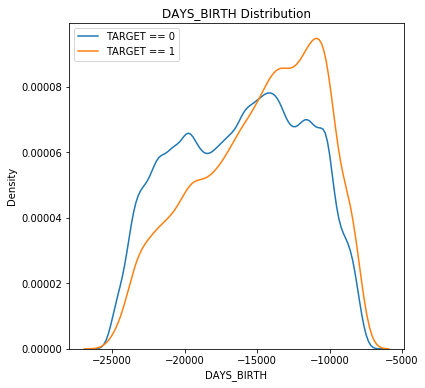

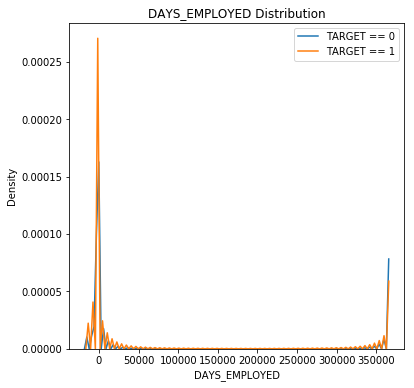

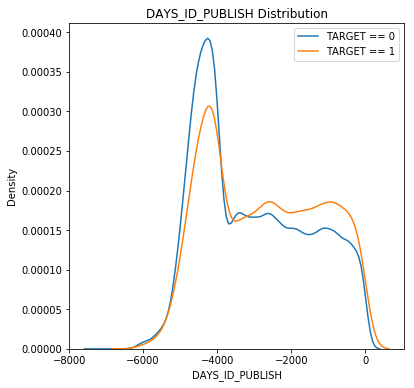

In [10]:
## kde plots for the highest 3 IV features
days = ['DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_ID_PUBLISH']
for name in days:
    mmf_kde_plot(X,Y, name)


In [11]:
## missing check for selected features
total_null = X_copy_select.isnull().sum()
percent = (X_copy_select.isnull().sum()/X_copy_select.isnull().count()*100)
missing_check  = pd.concat([total_null, percent], axis=1, keys=['Total Null', 'Percent']).sort_values(ascending = False, by = ['Percent'])
missing_check.head()

,Total Null,Percent
DAYS_BIRTH,0,0.0
DAYS_EMPLOYED,0,0.0
APARTMENTS_MEDI,0,0.0
REG_CITY_NOT_WORK_CITY,0,0.0
ELEVATORS_MODE,0,0.0


#### Use xgboost algorithm to build model
Since xgboost is an advanced algorithm, we directly use it to build model.
The main hyperparameters we need to tune are 'max_depth','reg_lambda', so we use cross validation and grid search to tune these parameters

In [12]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,cross_validate,GridSearchCV

propotion = sum(Y==0) / sum(Y==1)
##initial  model
model = xgb.XGBClassifier(learning_rate= 0.3, n_estimators=300,max_depth = 5, subsample = 0.8, reg_lambda = 1,scale_pos_weight = propotion,
num_parallel_tree = 5, eval_metric = 'auc',seed = 7,n_jobs=-1)

cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state = 7)

In [ ]:
''' it's slow
param1 = {'max_depth':range(4,9,2), 'reg_lambda' : [1,5,10,20]}
gsearch = GridSearchCV(estimator = model, param_grid = param1, scoring='roc_auc',n_jobs=-2, cv= 4)
gsearch.fit(X_copy_select,Y)
gsearch.best_estimator_;gsearch.best_params_;gsearch.cv_results_

param2 = {'max_depth':[3,4,5], 'reg_lambda' : [15,18,22,25]}
gsearch1 = GridSearchCV(model,param_grid = param2,scoring='roc_auc',n_jobs=-1, cv= cv).fit(X_copy_select,Y)
gsearch1.best_estimator_;gsearch1.best_params_;gsearch1.cv_results_
'''

#### check the performance(ROC curve and AUC) of the final model

We use ROC curve and AUC as our performance metrics because the target is very unbalanced with 0:1 = 11:1, and these metrics are very robust towards unbalanced data.

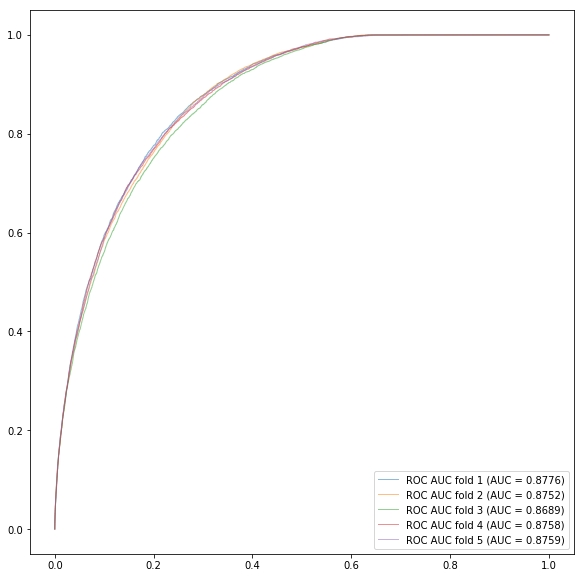

In [7]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
import matplotlib.pyplot as plt
final_model = xgb.XGBClassifier(learning_rate= 0.1, n_estimators=1000,max_depth = 3, subsample = 0.8, reg_lambda = 25,scale_pos_weight = propotion,
num_parallel_tree = 4, eval_metric = 'auc',seed = 7,n_jobs=-1)

#fold counter
fig1 = plt.figure(figsize=[10,10])
ax1 = fig1.add_subplot(111,aspect = 'equal')
i=1;aucs = []
for train,test in cv.split(X_copy_select,Y):
    prob = final_model.fit(X_copy_select.iloc[train],Y.iloc[train]).predict_proba(X_copy_select.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(Y.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC AUC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i= i+1
    
plt.legend(loc="lower right")

#### Lift chart for one fold in the validation
ROC curve is difficult to explain the business, so we also include lift curve. In this fold, the model still performs fairly good, as we go through 25% data, almost 80% positive target has been found, and 96.27% positive target has been found at 50% data, it indicates that the model is predictive to find those default targets.

In [13]:
from scipy import integrate
def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(round(val,4)*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(round(ar_value,4)))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()

      0         1
0   1.0  0.998069
1   1.0  0.996406
2   1.0  0.996122
3   1.0  0.995084
4   1.0  0.993978
5   1.0  0.992497
6   1.0  0.992191
7   1.0  0.992144
8   1.0  0.992007
9   1.0  0.991291
10  1.0  0.990519
11  1.0  0.990450
12  1.0  0.990119
13  1.0  0.989990
14  1.0  0.989982
15  1.0  0.989888
16  1.0  0.989754
17  1.0  0.989732
18  1.0  0.988857
19  1.0  0.988361


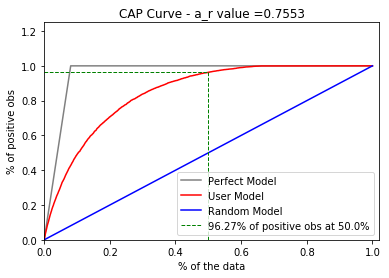

In [14]:
final_model = xgb.XGBClassifier(learning_rate= 0.1, n_estimators=1000,max_depth = 3, subsample = 0.8, reg_lambda = 25,scale_pos_weight = propotion,
num_parallel_tree = 4, eval_metric = 'auc',seed = 7,n_jobs=-1)

train,test = list(cv.split(X_copy_select,Y))[0]
prob = final_model.fit(X_copy_select.iloc[train],Y.iloc[train]).predict_proba(X_copy_select.iloc[test])[:,1]
capcurve(Y.iloc[test],prob)

#### Create new features
As we change feature values with WOE, so in this part, we need to go back to create new features and then bin features.
Max_score, Min_score, Mean_score are the maximum, minimum and mean of three external scores respectively;

EmployPropotion_AfterAdult is the percentage of length of employment to the time of the client being adult. Small number means short employment history, which can indicate future difficulties in paying off the loan;

Credit_Price_Ratio is the times of Credit to the goods price, usually, high number indicates strong payoff abaility

Credit_Annuity_Ratio is the times of Credit to the annuity, usually, low number indicates strong payoff abaility

Area_Avg_Apartment, Elevator_Avg_Apartment are average area of each apartment and average elevators of each apartment, high number indicates that people is rich so that the payoff ability is higher

In [39]:
X['DAYS_EMPLOYED'][X['DAYS_EMPLOYED'] > 0] = np.nan ##manipulate data
Max_score = pd.Series(np.nanmax(X_new[['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']],axis=1),index = X.index)
Min_score = pd.Series(np.nanmin(X_new[['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']],axis=1),index = X.index)
Mean_score = pd.Series(np.nanmean(X_new[['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']],axis=1),index = X.index)
EmployPropotion_AfterAdult = (-X_new['DAYS_BIRTH'] - 17*365) / (-X_new['DAYS_EMPLOYED'])
Credit_Price_Ratio = X_new['AMT_CREDIT'] / X_new['AMT_GOODS_PRICE'] 
Credit_Annuity_Ratio = X_new['AMT_CREDIT'] / X_new['AMT_ANNUITY']
Area_Avg_Apartment = X_new['TOTALAREA_MODE'] / X_new['APARTMENTS_AVG']
Elevator_Avg_Apartment = X_new['ELEVATORS_AVG'] / X_new['APARTMENTS_AVG']

In [40]:
col_name = list(X_copy_select.columns.values)
new_features  = ['Max_score','Min_score','Mean_score','EmployPropotion_AfterAdult','Credit_Price_Ratio','Credit_Annuity_Ratio','Area_Avg_Apartment','Elevator_Avg_Apartment']
for feature in new_features:
    col_name.append(feature)

X_new = X[X_copy_select.columns.values]
X_new = pd.concat([X_new,Max_score,Min_score,Mean_score,EmployPropotion_AfterAdult,Credit_Price_Ratio,Credit_Annuity_Ratio
           ,Area_Avg_Apartment,Elevator_Avg_Apartment],axis=1)
X_new.columns = col_name

In [42]:
#%%transform X_new like what we did before
iv = []
for i,name in enumerate(X_new.columns):
    x = X_new[name]
    if x.dtype == np.float64  and len(pd.unique(x)) > 8: ##check it's continuous or categorical feature, bin continuous feature
        x = BinTree(x,Y,min_impurity_decrease = 0.0001,groups = 8, depth = 5)
    woe = WOEIV(x,Y)[0]
    iv.append(WOEIV(x,Y)[2])
    for j,cate in enumerate(pd.unique(x)):
        temp = (x == cate) | (pd.isna(x))
        X_new.loc[temp,name] = woe[j] ##replace real value with weight of evidence
    X_new[name] = np.float64(X_new[name])

IV_new = pd.DataFrame(iv,index = X_new.columns,columns = ['IV']).sort_values(ascending=False,by = ['IV'])

In [51]:
##build model and cross validate
from sklearn.linear_model import LogisticRegression
LogModel = LogisticRegression(penalty = 'l2',C= 0.05, class_weight='balanced',random_state= 9,max_iter =500,n_jobs =-2)
'''
param2 = {'C': [0.1,1,5,10,20,50]}
gsearch2 = GridSearchCV(estimator = LogModel, param_grid = param2, scoring='roc_auc',n_jobs=-2, cv= cv)
gsearch2.fit(X_new,Y)
gsearch2.best_estimator_;gsearch2.best_params_;gsearch2.cv_results_

param3 = {'C': [0.01,0.05,0.1,0.2,0.5]}
gsearch3 = GridSearchCV(estimator = LogModel, param_grid = param3, scoring='roc_auc',n_jobs=-2, cv= cv)
gsearch3.fit(X_new,Y)
gsearch3.cv_results_
gsearch3.best_params_
'''

"\nparam2 = {'C': [0.1,1,5,10,20,50]}\ngsearch2 = GridSearchCV(estimator = LogModel, param_grid = param2, scoring='roc_auc',n_jobs=-2, cv= cv)\ngsearch2.fit(X_new,Y)\ngsearch2.best_estimator_;gsearch2.best_params_;gsearch2.cv_results_\n\nparam3 = {'C': [0.01,0.05,0.1,0.2,0.5]}\ngsearch3 = GridSearchCV(estimator = LogModel, param_grid = param3, scoring='roc_auc',n_jobs=-2, cv= cv)\ngsearch3.fit(X_new,Y)\ngsearch3.cv_results_\ngsearch3.best_params_\n"

#### Build Logistic Regression on those selected features without creating new features
The predictive power is merely slightly worse than XGBoost, and Logistic Model is much faster to build, so it may be more suitable to be deployed.

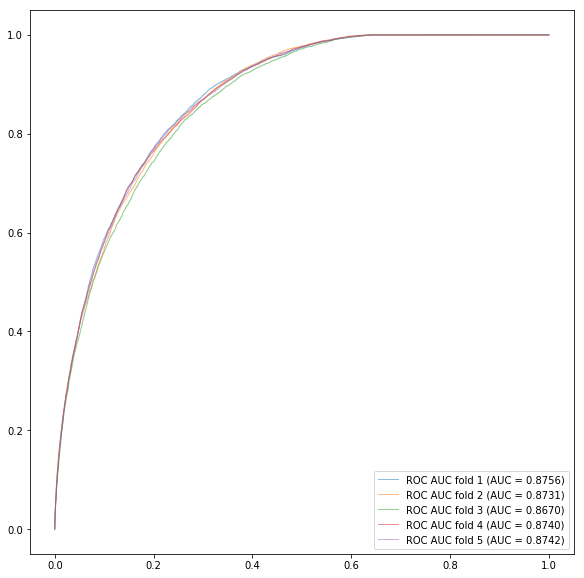

In [54]:
#fold counter
fig1 = plt.figure(figsize=[10,10])
ax1 = fig1.add_subplot(111,aspect = 'equal')
i=1;aucs = []
for train,test in cv.split(X_copy_select,Y):
    prob = LogModel.fit(X_copy_select.iloc[train],Y.iloc[train]).predict_proba(X_copy_select.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(Y.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC AUC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i= i+1

plt.legend(loc="lower right")

#### Build Logistic Regression with new features

As we can see, the predictive power decreases even though we include more features. This is an interesting finding, because it's not always good to create as many features as possible. Multicollinearity may cause the model perform worse, and we may need to do multivariate feature selection to decrease the effect of multicollinearity.

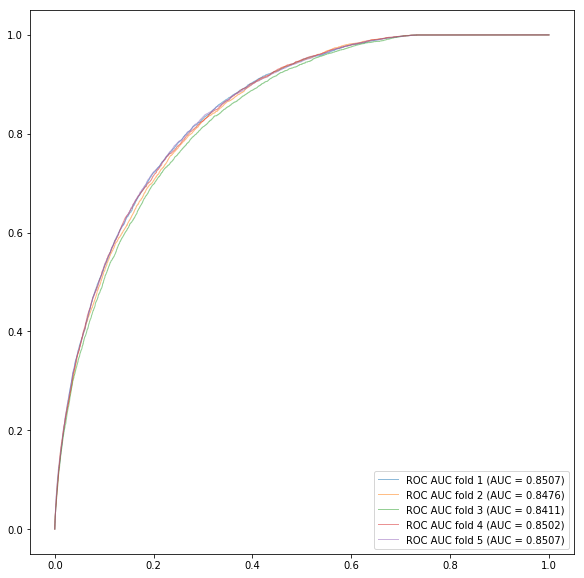

In [52]:
#fold counter
fig1 = plt.figure(figsize=[10,10])
ax1 = fig1.add_subplot(111,aspect = 'equal')
i=1;aucs = []
for train,test in cv.split(X_new,Y):
    prob = LogModel.fit(X_new.iloc[train],Y.iloc[train]).predict_proba(X_new.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(Y.iloc[test], prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC AUC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i= i+1

plt.legend(loc="lower right")